# Set Up

### Import required Python libraries and set plotting parameters 


In [1]:
!spack find -p tfel

-- linux-ubuntu20.04-x86_64 / gcc@9.4.0 -------------------------
tfel@4.0.0  /mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-mvfpqw7u4c23su7hj7g4leuwmykrjmcx
==> 1 installed package


In [2]:
# %env LD_LIBRARY_PATH=/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-mvfpqw7u4c23su7hj7g4leuwmykrjmcx/lib

In [3]:
!echo "$(spack find -p tfel | awk '/\/mofem_install\// {print $NF "/lib"}')"

/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-mvfpqw7u4c23su7hj7g4leuwmykrjmcx/lib


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import time
import os
import os.path
import zipfile
import pandas as pd
from scipy.optimize import curve_fit, least_squares
import sys
import gmsh
import math
import pyvista as pv
import re

from matplotlib.colors import ListedColormap
pv.set_plot_theme("document")

plt.rcParams['figure.figsize'] = [12, 9]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = "DejaVu Serif"
plt.rcParams['font.size'] = 20

from pyvirtualdisplay import Display
display = Display(backend="xvfb", visible=False, size=(800, 600))
display.start()
    
user_name=!whoami # get user name
user_name=user_name[0]
um_view = "/mofem_install/jupyter/%s/um_view" % user_name
#um_view = "/mofem_install/jupyter/callum/mofem_install/mofem-cephas/mofem/users_modules/um-build-Release-7q7t4mo"

# Custom 3D mesh

In [5]:
import sys
from pathlib import Path
sys.path.append('/mofem_install/jupyter/thomas/mfront_example_test/src')
import mesh_create as mshcrte
import custom_models as cm
import time
now = time.strftime("%Y_%m_%d_%H_%M_%S", time.localtime())
os.chdir('/mofem_install/jupyter/thomas/mfront_example_test')
mshcrte.test()
params = mshcrte.AttrDict()
# young modulus in Pa
params.pile_manager = cm.PileManager(x=0, y=0, z=10, dx=0, dy=0, dz=-20.5, R=1, r=0.975,
                              linear_elastic_properties=cm.LinearElasticProperties(youngs_modulus=200000*10**6, poisson_ratio=0.3)
                              )

soil_layer_1 = cm.SoilLayer(
    depth = -2,
    linear_elastic_properties=cm.LinearElasticProperties(youngs_modulus=96*10**6, poisson_ratio=0.3)
    )
soil_layer_2 = cm.SoilLayer(
    depth = -1.4,
    linear_elastic_properties=cm.LinearElasticProperties(youngs_modulus=182.1*10**6, poisson_ratio=0.3)
    )
soil_layer_3 = cm.SoilLayer(
    depth = -7.1,
    linear_elastic_properties=cm.LinearElasticProperties(youngs_modulus=351.3*10**6, poisson_ratio=0.3)
    )
soil_layer_4 = cm.SoilLayer(
    depth = -29.5,
    linear_elastic_properties=cm.LinearElasticProperties(youngs_modulus=668.4*10**6, poisson_ratio=0.3)
    )

params.force = cm.ForceBoundaryCondition(fx=1,fy=0,fz=0)
params.box_manager = cm.BoxManager(x=-80, y=-80, z=0, dx=160, dy=80,
    layers={
        1: soil_layer_1,
        2: soil_layer_2,
        3: soil_layer_3,
        4: soil_layer_4,
    },
    far_field_size=10,
    near_field_dist=5,
    near_field_size=1,
)


params.mesh_name = f"fx_{params.force.fx}_fy_{params.force.fy}_fz_{params.force.fz}_{now}"

params.data_dir = Path(f"/mofem_install/jupyter/thomas/mfront_example_test/data_{now}")
params.data_dir.mkdir(parents=True, exist_ok=True)
params.med_filepath = params.data_dir / f"{params.mesh_name}.med"
params.h5m_filepath = params.data_dir / f"{params.mesh_name}.h5m"
params.vtk_filepath = params.data_dir / f"{params.mesh_name}.vtk"

params.read_med_initial_log_file = params.data_dir / "read_med_log.txt"

# params.bc_time_history = params.data_dir / "disp_time.txt"
params.config_file = params.data_dir / "bc.cfg"
params.log_file = params.data_dir /  "indent.log"
if not os.path.exists(params.log_file):
    with open(params.log_file, 'w'): pass
    
params.template_sdf_file = "/mofem_install/jupyter/thomas/mfront_example_test/template_sdf.py"
params.sdf_file = "/mofem_install/jupyter/thomas/mfront_example_test/sdf.py"

params.nproc = 8 # number of processors/cores used
params.order = 2 #order of approximation functions

params.final_time = 1 # [s]
params.time_step = 1 # [s]

params.material_model = "LinearElasticity"
if params.material_model =="LinearElasticity":
    params.mi_block = cm.PropertyTypeEnum.elastic
params.show_mesh = False
    
    
print("far field bounding box:")
print(f"params.box_manager.min_x: {params.box_manager.min_x}")
print(f"params.box_manager.min_y: {params.box_manager.min_y}")
print(f"params.box_manager.min_z: {params.box_manager.min_z}")
print(f"params.box_manager.max_x: {params.box_manager.max_x}")
print(f"params.box_manager.max_y: {params.box_manager.max_y}")
print(f"params.box_manager.max_z: {params.box_manager.max_z}")
print("near field bounding box:")
print(f"params.box_manager.near_field_min_x: {params.box_manager.near_field_min_x}")
print(f"params.box_manager.near_field_min_y: {params.box_manager.near_field_min_y}")
print(f"params.box_manager.near_field_min_z: {params.box_manager.near_field_min_z}")
print(f"params.box_manager.near_field_max_x: {params.box_manager.near_field_max_x}")
print(f"params.box_manager.near_field_max_y: {params.box_manager.near_field_max_y}")
print(f"params.box_manager.near_field_max_z: {params.box_manager.near_field_max_z}")
params.show_mesh = True
geo = mshcrte.draw_mesh(params)
physical_groups = mshcrte.add_physical_groups(params, geo)

physical_groups = mshcrte.check_block_ids(params,physical_groups)
physical_groups = mshcrte.generate_config(params,physical_groups)
# sys.exit()


Hello world!
far field bounding box:
params.box_manager.min_x: -80.0
params.box_manager.min_y: -80.0
params.box_manager.min_z: -40.0
params.box_manager.max_x: 80.0
params.box_manager.max_y: 0.0
params.box_manager.max_z: 0.0
near field bounding box:
params.box_manager.near_field_min_x: -5.0
params.box_manager.near_field_min_y: -5.0
params.box_manager.near_field_min_z: -40.0
params.box_manager.near_field_max_x: 5.0
params.box_manager.near_field_max_y: 0.0
params.box_manager.near_field_max_z: 0.0
Done, taken Wall Time: 0.03 seconds, CPU Time: 0.03 seconds
Done, taken Wall Time: 1.18 seconds, CPU Time: 1.18 seconds
Done, taken Wall Time: 0.33 seconds, CPU Time: 0.00 seconds
dim=3 tags=[1] name='SOIL_LAYER_1' meshnet_id=8 group_type=<PhysicalGroupType.MATERIAL: 1> props={<PropertyTypeEnum.elastic: 1>: LinearElasticProperties(youngs_modulus=96000000.0, poisson_ratio=0.3)} bc=None
dim=3 tags=[2] name='SOIL_LAYER_2' meshnet_id=9 group_type=<PhysicalGroupType.MATERIAL: 1> props={<PropertyTypeEn

In [6]:
def partition_mesh(params):
    !read_med -med_file {params.med_filepath} -output_file {params.h5m_filepath} -meshsets_config {params.config_file} -log_sl inform
    
    params.part_file = os.path.splitext(params.h5m_filepath)[0] + "_" + str(params.nproc) + "p.h5m"
    #partition the mesh into nproc parts
    !{um_view}/bin/mofem_part \
    -my_file {params.h5m_filepath} \
    -my_nparts {params.nproc} \
    -output_file {params.part_file} \
    -dim 3 -adj_dim 2

# CUSTOM

In [7]:
def replace_template_sdf(params):
    regex = r"\{(.*?)\}"
    # print(os.getcwd())
    with open(params.template_sdf_file) as infile, open(params.sdf_file, 'w') as outfile:
        for line in infile:
            matches = re.finditer(regex, line, re.DOTALL)
            for match in matches:
                for name in match.groups():
                    src = "{" + name + "}"
                    target = str(1) #1 is a placeholder because it is not being used
                    line = line.replace(src, target)
            outfile.write(line)

def parse_log_file(filepath):
    force, time, area = [], [], []
    with open(filepath, "r") as log_file:
        for line in log_file:
            line = line.strip()
            if "Contact force:" in line:
                line = line.split()
                time.append(float(line[6]))
                force.append(float(line[10]))
            if "Contact area:" in line:
                line = line.split()
                area.append(float(line[8]))
    return time, force, area


def mofem_compute_force_indent(params):
    !rm -rf out*
    replace_template_sdf(params)
    
    mfront_arguments = []
    for physical_group in physical_groups:
        if physical_group.name.startswith("MFRONT_MAT"):
            mfront_block_id = physical_group.meshnet_id
            mi_block = "LinearElasticity"
            mi_param_0 = physical_group.props[cm.PropertyTypeEnum.elastic].youngs_modulus
            mi_param_1 = physical_group.props[cm.PropertyTypeEnum.elastic].poisson_ratio
            mi_param_2 = 0
            mi_param_3 = 0
            mi_param_4 = 0
            
            mfront_arguments.append(
                f"-mi_lib_path_{mfront_block_id} {um_view}/mfront_interface/libBehaviour.so "
                f"-mi_block_{mfront_block_id} {mi_block} "
                f"-mi_param_{mfront_block_id}_0 {mi_param_0} "
                f"-mi_param_{mfront_block_id}_1 {mi_param_1} "
                f"-mi_param_{mfront_block_id}_2 {mi_param_2} "
                f"-mi_param_{mfront_block_id}_3 {mi_param_3} "
                f"-mi_param_{mfront_block_id}_4 {mi_param_4} "
            )
    
    # Join mfront_arguments list into a single string
    mfront_arguments_str = ' '.join(mfront_arguments)


    command = (
        f"export OMPI_MCA_btl_vader_single_copy_mechanism=none && "
        f"nice -n 10 mpirun --oversubscribe --allow-run-as-root "
        f"-np {params.nproc} {um_view}/tutorials/adv-1/contact_3d "
        f"-file_name {params.part_file} "
        f"-sdf_file {params.sdf_file} "
        f"-order {params.order} "
        f"-contact_order 0 "
        f"-sigma_order 0 " #play around this in the future?
        f"-ts_dt {params.time_step} "
        f"-ts_max_time {params.final_time} "
        f"{mfront_arguments_str} "
        f"-mi_save_volume 1 "
        f"-mi_save_gauss 0 "
        f"2>&1 | tee {params.log_file}"
    )

    import subprocess
    result = subprocess.run(command, shell=True, text=True)
    
    time, react, area = parse_log_file(params.log_file)
    indent = np.asarray(time) * (1 / params.final_time)
    force = np.asarray(react)
    
    return indent, force, area

def show_results(params):
    out_to_vtk = !ls -c1 out_*h5m
    print(out_to_vtk)
    last_file=out_to_vtk[0]
    print(last_file)
    !mbconvert {last_file} {params.vtk_filepath}
    sys.exit()
    import pyvista as pv
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap
    import matplotlib.image as mpimg
    import re, os

    mesh = pv.read(params.vtk_filepath)

    mesh=mesh.warp_by_vector('DISPLACEMENT', factor=1)
    if params.show_edges:
        mesh=mesh.shrink(0.95)
    
    if params.show_field == "DISPLACEMENT" or params.show_field == "displacement":
        field = "DISPLACEMENT"
        if params.show_component == "X" or params.show_component == 'x':
            comp = 0
        elif params.show_component == "Y" or params.show_component == 'y':
            comp = 1
        else:
            print("Wrong component {0} of the field {1}".format(params.show_component, params.show_field))
            return
        
    if params.show_field == "STRESS" or params.show_field == "stress":
        field = "STRESS"
        if params.show_component == "X" or params.show_component == "x":
            comp = 0
        elif params.show_component == "Y" or params.show_component == "y":
            comp = 4
        elif params.show_component == "XY" or params.show_component == "xy":
            comp = 1
        else:
            print("Wrong component {0} of the field {1}".format(params.show_component, params.show_field))
            return

    p = pv.Plotter(notebook=True)
    p.add_mesh(mesh, scalars=field, component=comp, show_edges=True, smooth_shading=False, cmap="turbo")
    
    p.camera_position = "xy"
    p.show(jupyter_backend='ipygany')


In [8]:
elem_num_list = [20]
indent_list = []
force_list = []
for elem_num in elem_num_list:
    partition_mesh(params)
    indent, force, area = mofem_compute_force_indent(params)
    indent_list.append(indent)
    force_list.append(force)
    show_results(params)

[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 693a01d8ad1e79f10b1dc4f1dd785f311161b1d1
[0] <inform> Local time: 2024-8-16 11:43:15
[0] <inform> UTC time: 2024-8-16 11:43:15
[0] <inform> [MED] Reading MED file V4.1.0 using MED library V4.1.0
[0] <inform> [MED] Check mesh fx_1_fy_0_0_2024_08_16_11_43_13 nsteps 1
[0] <inform> [MED] Reading mesh fx_1_fy_0_0_2024_08_16_11_43_13 nsteps 1
[0] <inform> [MED] Read number of nodes 10666
[0] <inform> [MED] Reading elements 35 of type Vertex number of nodes 1
[0] <inform> [MED] Reading elements 1129 of type Edge number of nodes 2
[0] <inform> [MED] Reading elements 19560 of type Tri number of nodes 3
[0] <inform> [MED] Reading elements 37563 of type Tet number of nodes 4
[0] <inform> [read_med] Print all meshsets (old and added from meshsets configurational file)
[0] <inform> [read_med] meshset 12682136550675316737 type BLOCKSET UNKNOWNNAME msId 1 name fx_1_fy_0_0_2024_08_16_1

In [ ]:
print(indent_list)
print(force_list)
for elem_num, indent, force in zip(elem_num_list, indent_list, force_list):
    plt.plot(indent / params.indenter_radius, force, marker='o', ms=4, lw=1.5, label="MoFEM: {} elements per side".format(elem_num))
    
# plt.plot(indent/params.indenter_radius, hertz_press(indent, params), c='k', ls='--', label="Hertz formula", lw=2)

plt.xlabel("Normalised indentation, δ/R")
plt.ylabel("Force, nN")
plt.legend(loc='upper left')
plt.grid(ls=":")

In [ ]:
sys.exit()

# End of custom

### Define utility functions including black-box launch of MoFEM


In [ ]:
import gmsh
class AttrDict(dict):
    def __getattr__(self, attr):
        if attr in self:
            return self[attr]
        raise AttributeError(f"'AttrDict' object has no attribute '{attr}'")
    def __setattr__(self, key, value):
        self[key] = value
        
def replace_template_sdf(params):
    regex = r"\{(.*?)\}"
    # print(os.getcwd())
    with open(params.template_sdf_file) as infile, open(params.sdf_file, 'w') as outfile:
        for line in infile:
            matches = re.finditer(regex, line, re.DOTALL)
            for match in matches:
                for name in match.groups():
                    src = "{" + name + "}"
                    target = str(params[name])
                    line = line.replace(src, target)
            outfile.write(line)

def get_young_modulus(K, G):
    E = 9. * K * G /(3. * K + G)
    return E

def get_poisson_ratio(K, G):
    nu = (3. * K - 2. * G) / 2. / (3. * K + G)
    return nu

def get_bulk_modulus(E, nu):
    K = E / 3. / (1. - 2. * nu)
    return K

def get_shear_modulus(E, nu):
    G = E / 2. / (1. + nu)
    return G

def parse_log_file(filepath):
    force, time, area = [], [], []
    with open(filepath, "r") as log_file:
        for line in log_file:
            line = line.strip()
            if "Contact force:" in line:
                line = line.split()
                time.append(float(line[6]))
                force.append(float(line[10]))
            if "Contact area:" in line:
                line = line.split()
                area.append(float(line[8]))
    return time, force, area

def generate_config(params):
    with open(params.config_file, 'w') as f:
        data = [f"[block_2]", f"id={params.mfront_block_id}", "add=BLOCKSET", f"name=MFRONT_MAT_{params.mfront_block_id}"]
        for line in data:
            f.write(line + '\n')
    return

def mofem_compute_force_indent(params):
    !rm -rf out*
    
    mi_param_2 = 0
    mi_param_3 = 0
    mi_param_4 = 0
    
    if params.material_model == "LinearElasticity":
        mi_block = "LinearElasticity"
        mi_param_0 = params.young_modulus
        mi_param_1 = params.poisson_ratio
    elif params.material_model == "SaintVenantKirchhoffElasticity":
        mi_block = "SaintVenantKirchhoffElasticity"
        mi_param_0 = params.young_modulus
        mi_param_1 = params.poisson_ratio
    elif params.material_model == "NeoHookeanHyperElasticity":
        mi_block = "SignoriniHyperElasticity"
        mi_param_0 = get_bulk_modulus(params.young_modulus, params.poisson_ratio)
        mi_param_1 = 0.5 * get_shear_modulus(params.young_modulus, params.poisson_ratio)
    elif params.material_model == "StandardLinearSolid":
        mi_block = "StandardLinearSolid"
        mi_param_0 = get_bulk_modulus(params.young_modulus_0, params.poisson_ratio_0)
        mi_param_1 = get_shear_modulus(params.young_modulus_0, params.poisson_ratio_0)
        mi_param_2 = get_bulk_modulus(params.young_modulus_1, params.poisson_ratio_1)
        mi_param_3 = get_shear_modulus(params.young_modulus_1, params.poisson_ratio_1)
        mi_param_4 = params.relax_time_1
    else:
        print("Unknown material model: " + params.material_model)
        return
        
    replace_template_sdf(params)
        
    !export OMPI_MCA_btl_vader_single_copy_mechanism=none && \
    nice -n 10 mpirun --oversubscribe --allow-run-as-root \
    -np {params.nproc} {um_view}/tutorials/adv-1/contact_2d \
    -file_name {params.part_file} \
    -sdf_file {params.sdf_file} \
    -order {params.order} \
    -ts_dt {params.time_step} \
    -ts_max_time {params.final_time} \
    -mi_lib_path_{params.mfront_block_id} {um_view}/mfront_interface/libBehaviour.so \
    -mi_block_{params.mfront_block_id} {mi_block} \
    -mi_param_{params.mfront_block_id}_0 {mi_param_0} \
    -mi_param_{params.mfront_block_id}_1 {mi_param_1} \
    -mi_param_{params.mfront_block_id}_2 {mi_param_2} \
    -mi_param_{params.mfront_block_id}_3 {mi_param_3} \
    -mi_param_{params.mfront_block_id}_4 {mi_param_4} \
    -mi_save_volume 1 \
    -mi_save_gauss 0 \
    2>&1 | tee {params.log_file}

    time, react, area = parse_log_file(params.log_file)
    indent = np.asarray(time) * (params.max_indentation / params.final_time)
    force = np.asarray(react)
    
    return indent, force, area

def show_results(params):
    out_to_vtk = !ls -c1 out_*h5m
    print(out_to_vtk)
    last_file=out_to_vtk[0]
    print(last_file)
    !mbconvert {last_file} {last_file[:-3]}vtk
    
    import pyvista as pv
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap
    import matplotlib.image as mpimg
    import re, os

    mesh = pv.read(last_file[:-3] + "vtk")

    mesh=mesh.warp_by_vector('DISPLACEMENT', factor=1)
    if params.show_edges:
        mesh=mesh.shrink(0.95)
    
    if params.show_field == "DISPLACEMENT" or params.show_field == "displacement":
        field = "DISPLACEMENT"
        if params.show_component == "X" or params.show_component == 'x':
            comp = 0
        elif params.show_component == "Y" or params.show_component == 'y':
            comp = 1
        else:
            print("Wrong component {0} of the field {1}".format(params.show_component, params.show_field))
            return
        
    if params.show_field == "STRESS" or params.show_field == "stress":
        field = "STRESS"
        if params.show_component == "X" or params.show_component == "x":
            comp = 0
        elif params.show_component == "Y" or params.show_component == "y":
            comp = 4
        elif params.show_component == "XY" or params.show_component == "xy":
            comp = 1
        else:
            print("Wrong component {0} of the field {1}".format(params.show_component, params.show_field))
            return

    p = pv.Plotter(notebook=True)
    p.add_mesh(mesh, scalars=field, component=comp, show_edges=True, smooth_shading=False, cmap="turbo")
    
    # circle = pv.Circle(radius=params.indenter_radius, resolution=1000)
    # circle = circle.translate((0, params.indenter_radius - params.max_indentation, 0), inplace=False)
    # p.add_mesh(circle, color="grey")
    
    p.camera_position = "xy"
    p.show(jupyter_backend='ipygany')


def generate_mesh(params):
    gmsh.initialize()
    gmsh.model.add("Nanoindentation")
    
    a = params.refine_radius    
    H = params.mesh_height 
    L = params.mesh_length
    R = params.indenter_radius
    
    # Creating points
    tol = 1e-3
    
    print(a, H, R)
    new_model = False
    if new_model:
        point1 = gmsh.model.geo.addPoint(0, 0, 0, tol)
        
    
    
    if a < H / 2 and H > R:
        point1 = gmsh.model.geo.addPoint(0, 0, 0, tol)
        point2 = gmsh.model.geo.addPoint(0, -a, 0, tol)
        point3 = gmsh.model.geo.addPoint(a, 0, 0, tol)
        point4 = gmsh.model.geo.addPoint(0, -H, 0, tol)
        point5 = gmsh.model.geo.addPoint(L, -H, 0, tol)
        point6 = gmsh.model.geo.addPoint(L, 0, 0, tol)

        # Creating connection lines
        arc1 = gmsh.model.geo.addCircleArc(point3, point1, point2)
        line1 = gmsh.model.geo.addLine(point1, point2)
        line2 = gmsh.model.geo.addLine(point2, point4)
        line3 = gmsh.model.geo.addLine(point4, point5)
        line4 = gmsh.model.geo.addLine(point5, point6)
        line5 = gmsh.model.geo.addLine(point6, point3)
        line6 = gmsh.model.geo.addLine(point3, point1)

        loop1 = gmsh.model.geo.addCurveLoop([line1, -arc1, line6])
        surface1 = gmsh.model.geo.addPlaneSurface([loop1])

        loop2 = gmsh.model.geo.addCurveLoop([arc1, line2, line3, line4, line5])
        surface2 = gmsh.model.geo.addPlaneSurface([loop2])

        # This command is mandatory and synchronize CAD with GMSH Model. The less you launch it, the better it is for performance purpose
        gmsh.model.geo.synchronize()

        domain = gmsh.model.addPhysicalGroup(2, [surface1, surface2])
        gmsh.model.setPhysicalName(2, domain, '!_DOMAIN')
        contact = gmsh.model.addPhysicalGroup(1, [line5, line6])
        gmsh.model.setPhysicalName(1, contact, 'CONTACT')
        fix_x = gmsh.model.addPhysicalGroup(1, [line1, line2])
        gmsh.model.setPhysicalName(1, fix_x, 'FIX_X')
        fix_y = gmsh.model.addPhysicalGroup(1, [line3])
        gmsh.model.setPhysicalName(1, fix_y, 'FIX_Y')
        gmsh.model.mesh.setSize(gmsh.model.getEntitiesInBoundingBox(0, -H, 0, L, 0, 0), params.far_field_size)
        gmsh.model.mesh.setSize(gmsh.model.getEntitiesInBoundingBox(0, -a, 0, a, 0, 0), params.near_field_size)
    else:
        point1 = gmsh.model.geo.addPoint(0, 0, 0, tol)
        point2 = gmsh.model.geo.addPoint(0, -H, 0, tol)
        point3 = gmsh.model.geo.addPoint(H, -H, 0, tol)
        point4 = gmsh.model.geo.addPoint(H, 0, 0, tol)
        point5 = gmsh.model.geo.addPoint(L, -H, 0, tol)
        point6 = gmsh.model.geo.addPoint(L, 0, 0, tol)

        # Creating connection lines
        line1 = gmsh.model.geo.addLine(point1, point2)
        line2 = gmsh.model.geo.addLine(point2, point3)
        line3 = gmsh.model.geo.addLine(point3, point4)
        line4 = gmsh.model.geo.addLine(point4, point1)
        line5 = gmsh.model.geo.addLine(point3, point5)
        line6 = gmsh.model.geo.addLine(point5, point6)
        line7 = gmsh.model.geo.addLine(point6, point4)

        loop1 = gmsh.model.geo.addCurveLoop([line1, line2, line3, line4])
        surface1 = gmsh.model.geo.addPlaneSurface([loop1])

        loop2 = gmsh.model.geo.addCurveLoop([-line3, line5, line6, line7])
        surface2 = gmsh.model.geo.addPlaneSurface([loop2])

        # This command is mandatory and synchronize CAD with GMSH Model. The less you launch it, the better it is for performance purpose
        gmsh.model.geo.synchronize()

        domain = gmsh.model.addPhysicalGroup(2, [surface1, surface2])
        gmsh.model.setPhysicalName(2, domain, '!_DOMAIN')
        contact = gmsh.model.addPhysicalGroup(1, [line7, line4])
        gmsh.model.setPhysicalName(1, contact, 'CONTACT')
        fix_x = gmsh.model.addPhysicalGroup(1, [line1])
        gmsh.model.setPhysicalName(1, fix_x, 'FIX_X')
        fix_y = gmsh.model.addPhysicalGroup(1, [line2, line5])
        gmsh.model.setPhysicalName(1, fix_y, 'FIX_Y1')
        
        gmsh.model.mesh.setSize(gmsh.model.getEntitiesInBoundingBox(0, -H, 0, L, 0, 0), params.far_field_size)
        gmsh.model.mesh.setSize(gmsh.model.getEntitiesInBoundingBox(0, -H, 0, H, 0, 0), params.near_field_size)
        
    gmsh.model.mesh.generate(2)    

    # Save mesh
    gmsh.write(params.med_file)

    # Finalize GMSH = END OF CODE=
    gmsh.finalize()
    
    generate_config(params)
    
    !read_med -med_file {params.med_file} -output_file {params.mesh_file} -meshsets_config {params.config_file} -log_sl inform
    
    params.part_file = os.path.splitext(params.mesh_file)[0] + "_" + str(params.nproc) + "p.h5m"
    #partition the mesh into nproc parts
    !{um_view}/bin/mofem_part \
    -my_file {params.mesh_file} \
    -my_nparts {params.nproc} \
    -output_file {params.part_file} \
    -dim 2 -adj_dim 1
    
    if params.show_mesh:
        !mbconvert {params.mesh_file} {params.vtk_file}

        mesh = pv.read(params.vtk_file )
        mesh = mesh.shrink(0.95)

        p = pv.Plotter(notebook=True)
        p.add_mesh(mesh, smooth_shading=False)

        circle = pv.Circle(radius=params.indenter_radius, resolution=1000)
        circle = circle.translate((0, params.indenter_radius, 0), inplace=False)

        p.add_mesh(circle, color="grey")
        p.camera_position = "xy"
        p.show(jupyter_backend='ipygany')
    
    return

def hertz_press(indent, params):   
    Es = params.young_modulus / (1 - params.poisson_ratio**2)    
    return 4./3. * Es * np.sqrt(params.indenter_radius) * pow(indent, 3./2.)

def hertz_area(indent, params):   
    return np.pi * indent * params.indenter_radius


### Sketch of the problem setup

<!-- 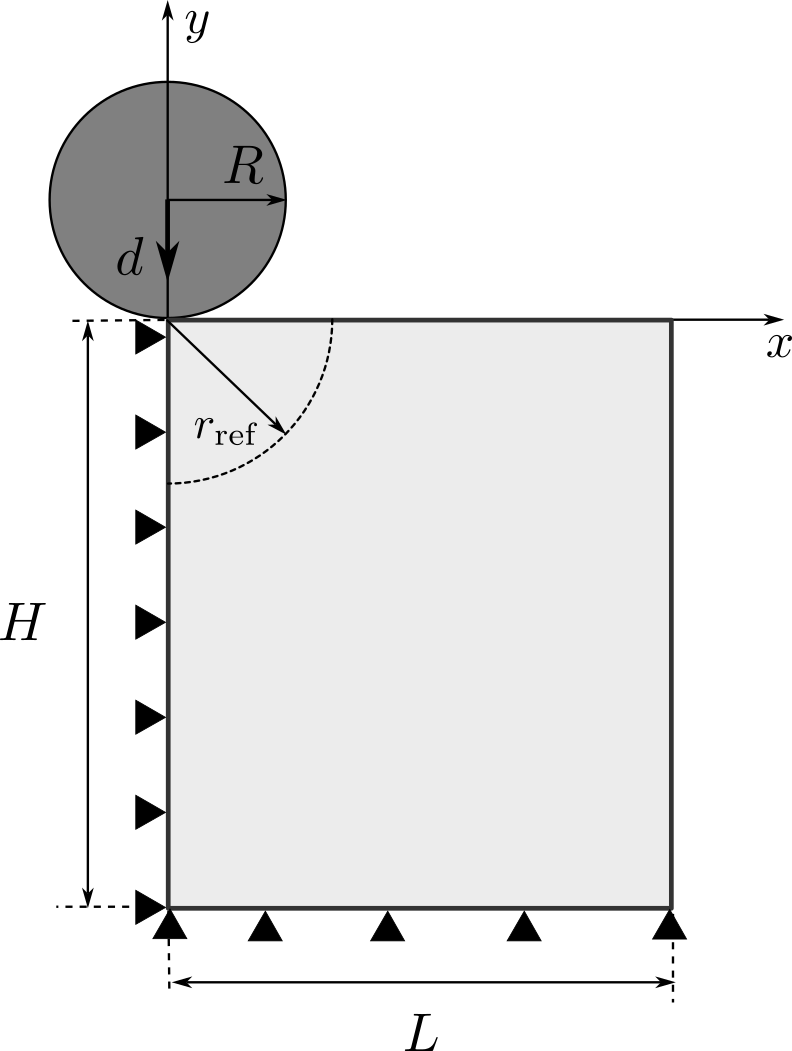 -->

<div>
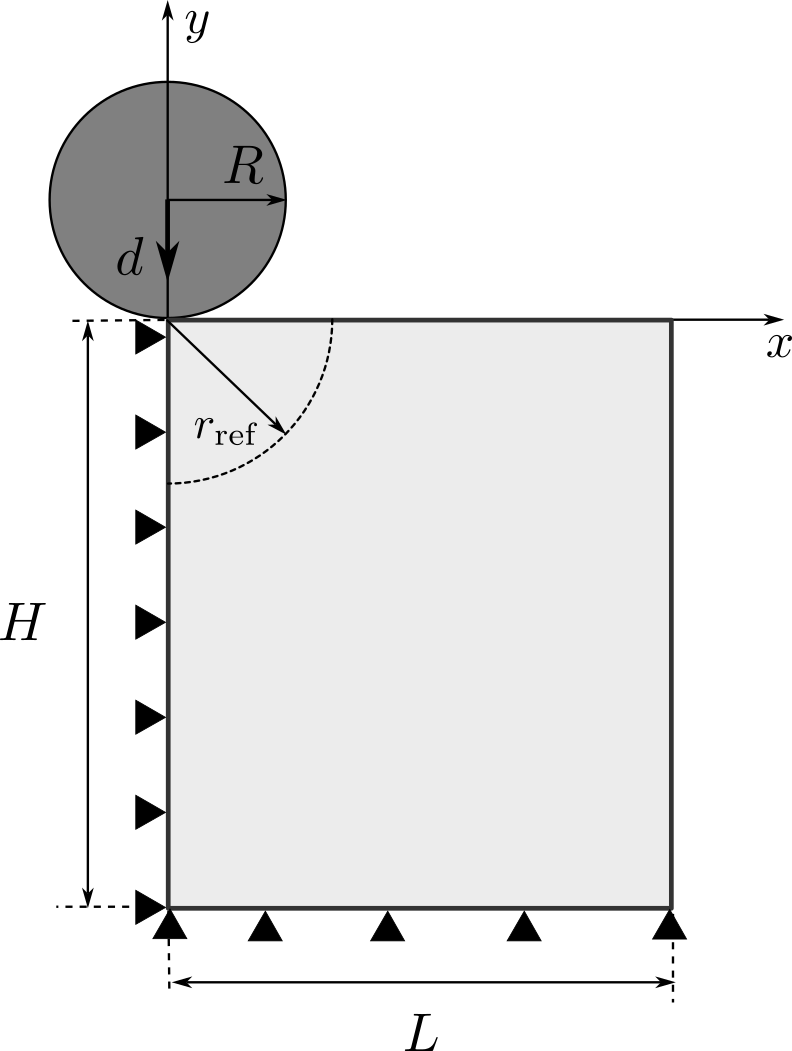
</div>

### Set simulation parameters

In [ ]:
import numpy as np
params = AttrDict()

params.med_file = "mesh_2d.med"
params.mesh_file = "mesh_2d.h5m"
params.vtk_file = "mesh_2d.vtk"

params.load_hist = "load.txt"
params.log_file = "log_indent"
# wd = f"/mofem_install/jupyter/{user_name}/mfront_example_test"
# os.chdir(wd)
# params.template_sdf_file = wd + "/" + "template_sdf.py"
# params.sdf_file = wd + "/" + "sdf.py"

params.config_file = "bc.cfg"
params.mfront_block_id = 10

params.nproc = 8 # number of processors/cores used
params.order = 2 #order of approximation functions

params.final_time = 1 # [s]
params.time_step = 0.05 # [s]

params.indenter_radius = 10 
params.max_indentation = 1
params.refine_radius = np.sqrt(params.indenter_radius * params.max_indentation) # a_hertz = sqrt(R * d)

params.mesh_length = params.refine_radius * 50 # L
params.mesh_height = params.mesh_length * 2    # H

params.far_field_size = params.mesh_height / 10
params.near_field_size = params.refine_radius / 10

### Generate and visualise the mesh

In [ ]:
params.show_mesh = True
generate_mesh(params)

### Convergence w.r.t. number of elements per side

In [ ]:
# elem_num_list = [2, 5, 10, 20]
elem_num_list = [20]
indent_list = []
force_list = []

params.young_modulus = 100
params.poisson_ratio = 0.45
params.material_model = "LinearElasticity"
params.show_mesh = False

for elem_num in elem_num_list:
    params.far_field_size = params.mesh_height / elem_num
    params.near_field_size = params.refine_radius / elem_num
    generate_mesh(params)
    
    indent, force, area = mofem_compute_force_indent(params)
    indent_list.append(indent)
    force_list.append(force)

In [ ]:
for elem_num, indent, force in zip(elem_num_list, indent_list, force_list):
    plt.plot(indent / params.indenter_radius, force, marker='o', ms=4, lw=1.5, label="MoFEM: {} elements per side".format(elem_num))
    
plt.plot(indent/params.indenter_radius, hertz_press(indent, params), c='k', ls='--', label="Hertz formula", lw=2)

plt.xlabel("Normalised indentation, δ/R")
plt.ylabel("Force, nN")
plt.legend(loc='upper left')
plt.grid(ls=":")

### Convergence w.r.t. mesh height

In [ ]:
length_mult_list = [5, 10, 20, 40]
indent_list = []
force_list = []

params.young_modulus = 100
params.poisson_ratio = 0.45
params.material_model = "LinearElasticity"

params.show_mesh = False

for length_mult in length_mult_list:
    params.mesh_length = params.refine_radius * length_mult
    params.mesh_height = params.mesh_length * 2
    
    params.far_field_size = params.mesh_height / 10
    params.near_field_size = params.refine_radius / 10

    generate_mesh(params)
    
    indent, force, area = mofem_compute_force_indent(params)
    indent_list.append(indent)
    force_list.append(force)

In [ ]:
for length_mult, indent, force in zip(length_mult_list, indent_list, force_list):
    plt.plot(indent / params.indenter_radius, force, marker='o', ms=4, lw=1.5, label="MoFEM: mesh length mult {}".format(length_mult))
    
plt.plot(indent/params.indenter_radius, hertz_press(indent, params), c='k', ls ='--', label="Hertz formula", lw=2)

plt.xlabel("Normalised indentation, δ/R")
plt.ylabel("Force, nN")
plt.legend(loc='upper left')
plt.grid(ls=":")

# Comparison of different elastic models

In [ ]:
params.far_field_size = params.mesh_height / 10
params.near_field_size = params.refine_radius / 10

params.mesh_length = params.refine_radius * 40
params.mesh_height = params.mesh_length * 2

params.indenter_radius = 10 
params.max_indentation = 10 

params.refine_radius = np.sqrt(params.indenter_radius * params.max_indentation) # a_hertz = sqrt(R * d)

params.mesh_length = params.refine_radius * 40
params.mesh_height = params.mesh_length * 2

params.far_field_size = params.mesh_height / 10
params.near_field_size = params.refine_radius / 10

params.show_mesh = True
generate_mesh(params)

In [ ]:
params.young_modulus = 100
params.poisson_ratio = 0.49
params.material_model = "LinearElasticity"

indent_1, force_1, area_1 = mofem_compute_force_indent(params)

In [ ]:
params.young_modulus = 100
params.poisson_ratio = 0.49
params.material_model = "NeoHookeanHyperElasticity"

indent_2, force_2, area_2 = mofem_compute_force_indent(params)

### Comparison of the force evolution

In [ ]:
plt.plot(indent_1/params.indenter_radius, force_1, marker='o', ms=6, label="MoFEM LinearElasticity", lw=1.5)
plt.plot(indent_2/params.indenter_radius, force_2, marker='o', ms=6, label="MoFEM NeoHookeanHyperElasticity", lw=1.5)

plt.plot(indent_1/params.indenter_radius, hertz_press(indent_1, params), c='k', ls='--', label="Hertz formula", lw=2)

plt.xlabel("Normalised indentation, δ/R")
plt.ylabel("Force, nN")
plt.legend(loc='upper left')
plt.grid()

### Comparison of the contact area evolution

In [ ]:
plt.plot(indent_1/params.indenter_radius, area_1, marker='o', ms=6, label="MoFEM LinearElasticity", lw=1.5)
plt.plot(indent_2/params.indenter_radius, area_2, marker='o', ms=6, label="MoFEM NeoHookeanHyperElasticity", lw=1.5)

plt.plot(indent_2/params.indenter_radius, hertz_area(indent_2, params), label="Hertz formula", lw=2)

plt.xlabel("Normalised indentation, δ/R")
plt.ylabel("Contact area, um2")
plt.legend(loc='upper left')
plt.grid()

### Visualisation of the deformation

In [ ]:
params.show_field = "DISPLACEMENT"
params.show_component = "Y"
params.show_edges = False

show_results(params)

In [ ]:
params.show_field = "STRESS"
params.show_component = "Y"
params.show_edges = True

show_results(params)

## Indentation of a thin layer

In [ ]:
params.max_indentation = params.indenter_radius / 2
params.mesh_height = params.indenter_radius 
params.refine_radius = np.sqrt(params.indenter_radius * params.max_indentation) # a_hertz = sqrt(R * d)

params.mesh_length = params.refine_radius * 10
params.far_field_size = params.mesh_length / 10
params.near_field_size = params.mesh_height / 10

params.show_mesh = True
generate_mesh(params)

params.young_modulus = 100
params.poisson_ratio = 0.49
params.material_model = "NeoHookeanHyperElasticity"

mofem_compute_force_indent(params)

In [ ]:
params.show_field = "DISPLACEMENT"
params.show_component = "X"
params.show_edges = True

show_results(params)

In [ ]:
params.show_field = "STRESS"
params.show_component = "X"
params.show_edges = True

show_results(params)

In [ ]:
height_mult_list = [1, 2, 4, 8, 16]
indent_list = []
force_list = []

params.indenter_radius = 10 
params.max_indentation = 5

params.young_modulus = 100
params.poisson_ratio = 0.49
params.material_model = "NeoHookeanHyperElasticity"

params.refine_radius = np.sqrt(params.indenter_radius * params.max_indentation) # a_hertz = sqrt(R * d)

params.mesh_length = params.refine_radius * 50

    
params.near_field_size = params.refine_radius / 10
params.far_field_size = params.mesh_length / 10

params.show_mesh = False

for height_mult in height_mult_list:
    params.mesh_height = params.indenter_radius * height_mult
    
    generate_mesh(params)
    
    indent, force, area = mofem_compute_force_indent(params)
    indent_list.append(indent)
    force_list.append(force)

In [ ]:
for elem_num, indent, force in zip(height_mult_list, indent_list, force_list):
    plt.plot(indent / params.indenter_radius, force, marker='o', ms=4, lw=1.5, label="MoFEM: H / R = {}".format(elem_num))
    
plt.plot(indent/params.indenter_radius, hertz_press(indent, params), c='k', ls='--', label="Hertz formula", lw=2)

plt.xlabel("Normalised indentation, δ/R")
plt.ylabel("Force, nN")
plt.legend(loc='upper left')
plt.grid(ls=":")